In [1]:
!pip install emoji urlextract stanza Sastrawi transformers torch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import re
import string
import emoji
import pandas as pd
import requests
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import stanza
import os

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from urlextract import URLExtract
from tqdm.auto import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

warnings.filterwarnings("ignore")

# **Import Data**

In [3]:
os.makedirs("/content/Raw_Dataset/", exist_ok=True)

file_names = [f"coretax-pt{name}.csv" for name in range(1, 13)]

for file_name in file_names:
    url = f"https://raw.githubusercontent.com/rioooranteai/nlp-simple-project/main/Analisis%20Sentimen%20-%20Coretax/Dataset/Raw%20Data/{file_name}"
    output_path = f"/content/Raw_Dataset/{file_name}"

    response = requests.get(url)
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            f.write(response.content)
        print(f"Berhasil mengunduh {file_name}")
    else:
        print(f"Gagal mengunduh {file_name}: Status code {response.status_code}")

Berhasil mengunduh coretax-pt1.csv
Berhasil mengunduh coretax-pt2.csv
Berhasil mengunduh coretax-pt3.csv
Berhasil mengunduh coretax-pt4.csv
Berhasil mengunduh coretax-pt5.csv
Berhasil mengunduh coretax-pt6.csv
Berhasil mengunduh coretax-pt7.csv
Berhasil mengunduh coretax-pt8.csv
Berhasil mengunduh coretax-pt9.csv
Berhasil mengunduh coretax-pt10.csv
Berhasil mengunduh coretax-pt11.csv
Berhasil mengunduh coretax-pt12.csv


In [4]:
dfs = [pd.read_csv(os.path.join("/content/Raw_Dataset/", f)) for f in file_names]
df = pd.concat(dfs, ignore_index=True)

df = df[['full_text']].dropna().drop_duplicates().reset_index(drop=True)

# **Text Preprocessing**

In [5]:
data = df.copy(deep=True)

### **Remove Unnecesary Character**

In [6]:
extractor = URLExtract()

def data_cleaning_pipeline_v2(text: str) -> str:
    """
    Praproses teks tweet:
    1. Konversi emoji ke teks deskriptif.
    2. Ganti URL dengan placeholder <URL>.
    3. Hapus mention @user.
    4. Jaga isi hashtag (hilangkan '#').
    5. Pertahankan semua tanda baca.
    6. Hapus spasi sebelum tanda baca (. , ! ?).
    7. Konsolidasikan whitespace.
    8. Lowercase.
    """
    text = str(text)

    text = emoji.demojize(text)

    text = re.sub(r":([a-z0-9_+-]+):", r"\1", text)

    for url in extractor.find_urls(text):
        text = text.replace(url, '<URL>')

    text = re.sub(r"@\w+", '', text)

    text = re.sub(r"#(\w+)", r"\1", text)

    text = re.sub(r"\s+([?.!,])", r"\1", text)

    text = text.lower()

    text = re.sub(r"\s+", ' ', text).strip()

    return text

### **Remove Stopwords**

In [7]:
factory = StopWordRemoverFactory()
stopwords = set(factory.get_stop_words())

def remove_stopwords(text: str) -> str:
    tokens = text.split()
    return ' '.join([t for t in tokens if t not in stopwords])

### **Lemmatizaton**

In [8]:
stanza.download('id', package='csui')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading these customized packages for language: id (Indonesian)...
| Processor       | Package       |
-----------------------------------
| tokenize        | csui          |
| mwt             | csui          |
| pos             | csui_charlm   |
| lemma           | csui_nocharlm |
| depparse        | csui_charlm   |
| forward_charlm  | oscar2023     |
| backward_charlm | oscar2023     |
| pretrain        | conll17       |



INFO:stanza:Downloaded file to /root/stanza_resources/id/tokenize/csui.pt


INFO:stanza:Downloaded file to /root/stanza_resources/id/mwt/csui.pt


INFO:stanza:Downloaded file to /root/stanza_resources/id/pos/csui_charlm.pt


INFO:stanza:Downloaded file to /root/stanza_resources/id/lemma/csui_nocharlm.pt


INFO:stanza:Downloaded file to /root/stanza_resources/id/depparse/csui_charlm.pt


INFO:stanza:Downloaded file to /root/stanza_resources/id/forward_charlm/oscar2023.pt


INFO:stanza:Downloaded file to /root/stanza_resources/id/backward_charlm/oscar2023.pt


INFO:stanza:Downloaded file to /root/stanza_resources/id/pretrain/conll17.pt
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


In [9]:
nlp = stanza.Pipeline(lang='id', processors='tokenize,pos,lemma', package='csui')

tqdm.pandas()

def lemmastanza(teks):
    doc = nlp(teks)
    return " ".join([word.lemma for sentence in doc.sentences for word in sentence.words])

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: id (Indonesian):
| Processor | Package       |
-----------------------------
| tokenize  | csui          |
| mwt       | csui          |
| pos       | csui_charlm   |
| lemma     | csui_nocharlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [10]:
print("Cleaning...")
data['full_text'] = data['full_text'].progress_apply(data_cleaning_pipeline_v2)
data = data[data['full_text'] != ''].drop_duplicates('full_text').reset_index(drop=True)

print("Stopwords removal...")
data['full_text'] = data['full_text'].apply(remove_stopwords)

print("Lemmatization...")
data['full_text'] = data['full_text'].progress_apply(lemmastanza)

Cleaning...


  0%|          | 0/15693 [00:00<?, ?it/s]

Stopwords removal...
Lemmatization...


  0%|          | 0/14697 [00:00<?, ?it/s]

In [11]:
data.to_csv('Dataset_Unclassified.csv', index=False)

# **Labeling Data**

In [12]:
data_1 = data.copy(deep=True)
data_2 = data.copy(deep=True)

### **Model 1**

In [16]:
roberta_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
roberta_pipe = pipeline('sentiment-analysis', model=roberta_name, tokenizer=roberta_name)

valid_texts = [text for text in data_1['full_text'] if isinstance(text, str) and text]

def predict(text):
    if isinstance(text, str):
        if text:
            return roberta_pipe([text])[0]['label']
        else:
            return 'neutral'
    else:
        return 'neutral'

data_1['sentiment'] = data_1['full_text'].progress_apply(predict)

Device set to use cuda:0


  0%|          | 0/14697 [00:00<?, ?it/s]

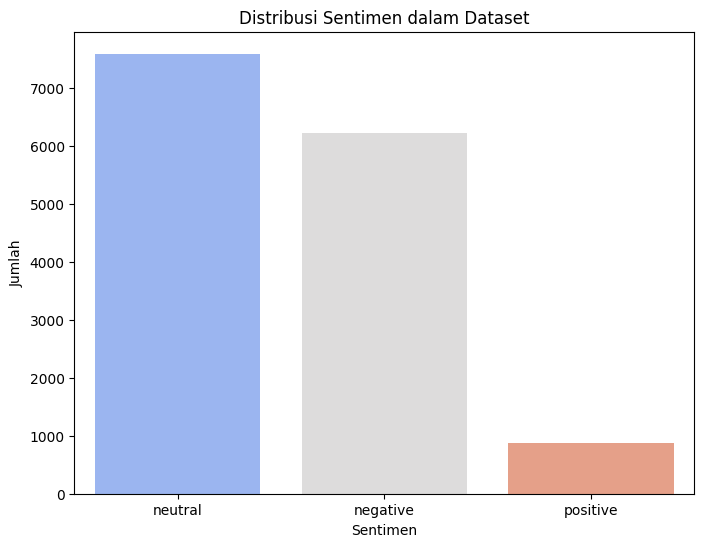

In [17]:
sentiment_counts = data_1['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Distribusi Sentimen dalam Dataset")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()

In [18]:
data_1.to_csv('Dataset_roberta.csv', index=False)

### **Model 2**

In [19]:
bert_name = "mdhugol/indonesia-bert-sentiment-classification"
tokenizer2 = AutoTokenizer.from_pretrained(bert_name)
model2 = AutoModelForSequenceClassification.from_pretrained(bert_name)
bert_pipe = pipeline('sentiment-analysis', model=model2, tokenizer=tokenizer2)

label_map = {'LABEL_0': 'negative', 'LABEL_1': 'neutral', 'LABEL_2': 'positive'}
res2 = bert_pipe(list(data_2['full_text']), batch_size=32)

data_2['sentiment'] = [label_map.get(r['label'], 'neutral') for r in res2]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

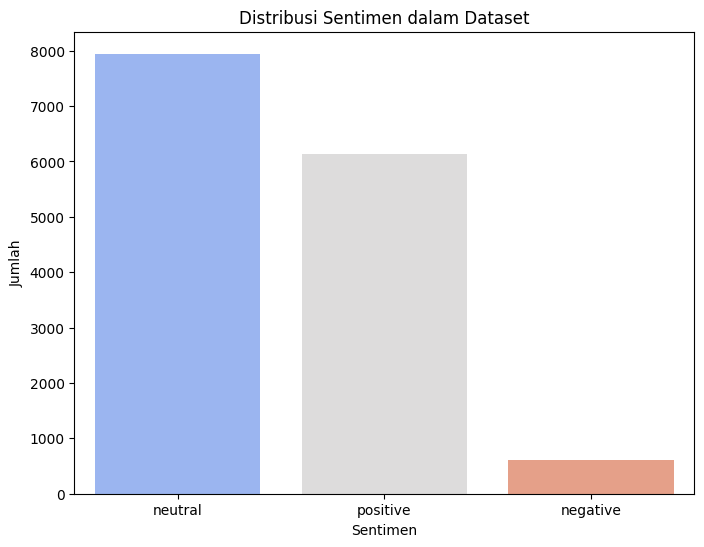

In [20]:
sentiment_counts = data_2['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Distribusi Sentimen dalam Dataset")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.show()

In [21]:
data_2.to_csv('Dataset_bert.csv', index=False)